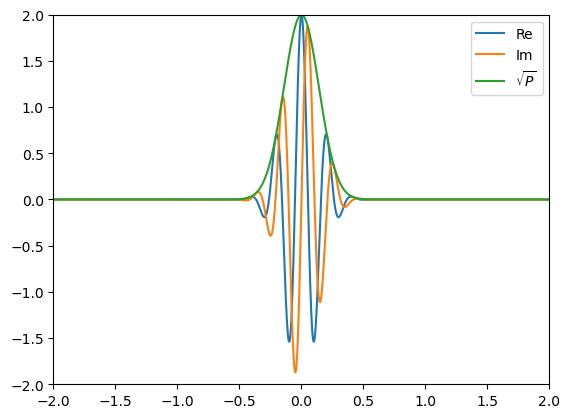

In [6]:
import numpy as np
x = np.linspace(-10,10,5000)
deltax = x[1]-x[0]

def norm(phi):
    norm = np.sum(np.square(np.abs(phi)))*deltax
    return phi/np.sqrt(norm)

def complex_plot(x,y,prob=True,**kwargs):
    real = np.real(y)
    imag = np.imag(y)
    a,*_ = plt.plot(x,real,label='Re',**kwargs)
    b,*_ = plt.plot(x,imag,label='Im',**kwargs)
    plt.xlim(-2,2)
    if prob:
        p,*_ = plt.plot(x,np.abs(y),label='$\sqrt{P}$')
        return a,b,p
    else:
        return a,b
    
def wave_packet(pos=0,mom=0,sigma=0.2):
    return norm(np.exp(-1j*mom*x)*np.exp(-np.square(x-pos)/sigma/sigma,dtype=complex))
                
def d_dxdx(phi,x=x):
    dphi_dxdx = -2*phi
    dphi_dxdx[:-1] += phi[1:]
    dphi_dxdx[1:] += phi[:-1]
    return dphi_dxdx/deltax

def d_dt(phi,h=1,m=100,V=0):
    return 1j*h/2/m * d_dxdx(phi) - 1j*V*phi/h

def euler(phi, dt, **kwargs):
    return phi + dt * d_dt(phi, **kwargs)

def rk4(phi, dt, **kwargs):
    k1 = d_dt(phi, **kwargs)
    k2 = d_dt(phi+dt/2*k1, **kwargs)
    k3 = d_dt(phi+dt/2*k2, **kwargs)
    k4 = d_dt(phi+dt*k3, **kwargs)
    return phi + dt/6*(k1+2*k2+2*k3+k4)

def simulate(phi_sim, 
             method='euler', 
             V=0, 
             steps=100000, 
             dt=1e-1, 
             condition=None, 
             normalize=True,
             save_every=100):
    simulation_steps = [np.copy(phi_sim)]
    for i in range(steps):
        if method == 'euler':
            phi_sim = euler(phi_sim,dt,V=V)
        elif method == 'rk4':
            phi_sim = rk4(phi_sim,dt,V=V)
        else:
            raise Exception(f'Unknown method {method}')
        if condition:
            phi_sim = condition(phi_sim)
        if normalize:
            phi_sim = norm(phi_sim)
        if save_every is not None and (i+1) % save_every == 0:
            simulation_steps.append(np.copy(phi_sim))
    return simulation_steps

sim_free = simulate(wave_packet(mom=-30),steps=200000,save_every=1000)#wave_packet()

from matplotlib.animation import FuncAnimation

import matplotlib.pyplot as plt

def animate(simulation_steps,init_func=None):
    fig = plt.figure()
    re,im,prob = complex_plot(x,simulation_steps[0])
    plt.xlim(-2,2)
    plt.ylim(-2,2)
    if init_func:
        init_func()
    plt.legend()

    def animate(frame):
        prob.set_data((x, np.abs(simulation_steps[frame])))
        re.set_data((x, np.real(simulation_steps[frame])))
        im.set_data((x, np.imag(simulation_steps[frame])))
        return prob,re,im

    anim = FuncAnimation(fig, animate, frames=int(len(simulation_steps)), interval=50)
    plt.ioff()
    plt.show()

    return anim

animate(sim_free)